# Climate Anlysis and Exploration
March 26, 2019  
Scott McEachern

In [1]:
#-- Import Dependency

#- Charting
%matplotlib inline

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta


#- Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


# Reflect Tables into SQLAlchemy ORM

In [2]:
#- Create Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


#- Reflect the Tables
Base = automap_base()
Base.prepare(engine, reflect=True)


#- Display Tables found
Base.classes.keys()

['measurement', 'station']

In [3]:
#- Reference Tables
Measurement = Base.classes.measurement
Station = Base.classes.station


#- Create Session
session = Session(engine)

# Exploratory Climate Analysis

In [4]:
def printColumnNames(inspector, tableName):
    '''Prints column metadata
    
    Accepts : inspector (inspect) reference to sqlalchemy inspect used to get metadata
              tableName (str) name of table to get metadata
    '''
    
    print(f"--->  {tableName}")
    
    columns = inspector.get_columns(tableName)

    for column in columns:
        print(f"{column['name']}  {column['type']}")

In [5]:
#- View Columns: Measurement
inspector = inspect(engine)

printColumnNames(inspector, 'measurement')

print(" ")
printColumnNames(inspector, 'station')


--->  measurement
id  INTEGER
station  TEXT
date  TEXT
prcp  FLOAT
tobs  FLOAT
 
--->  station
id  INTEGER
station  TEXT
name  TEXT
latitude  FLOAT
longitude  FLOAT
elevation  FLOAT


## 1.1 Precipitation Analysis
* Design a query to retrieve the last 12 months of precipitation data.
* Select only the date and prcp values.
* Load the query results into a Pandas DataFrame and set the index to the date column.
* Sort the DataFrame values by date.
* Plot the results using the DataFrame plot method.

In [6]:
#-- Determine Dates

#- Last date in dataset
lastDateString = session.query(func.max(Measurement.date)).scalar()


#- Convert to DateTime from String
lastDate = datetime.strptime(lastDateString, '%Y-%m-%d')


#- 12 Months from last date
startDate = lastDate - relativedelta(years=1)


#- Display Dates
print(f"Query start date: {startDate}")
print(f"Query end date: {lastDate}")

Query start date: 2016-08-23 00:00:00
Query end date: 2017-08-23 00:00:00


In [7]:
#-- Create DataFrame

#- Columns for dataframe
sel = [Measurement.date,
      Measurement.prcp]


#- Create List of Records
records = session.query(*sel).filter(Measurement.date.between(startDate, lastDate)).all()


#- Create DataFrame
dateColumn = 'Date'
prcpColumn = 'Precipitation'
precipitation_df = pd.DataFrame(records, columns=[dateColumn, prcpColumn])


#- Set Index on Date
precipitation_df.set_index(dateColumn, inplace=True)


#- Sort by Date
precipitation_df = precipitation_df.sort_values(by=[dateColumn])


#- Preview DataFrame
precipitation_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


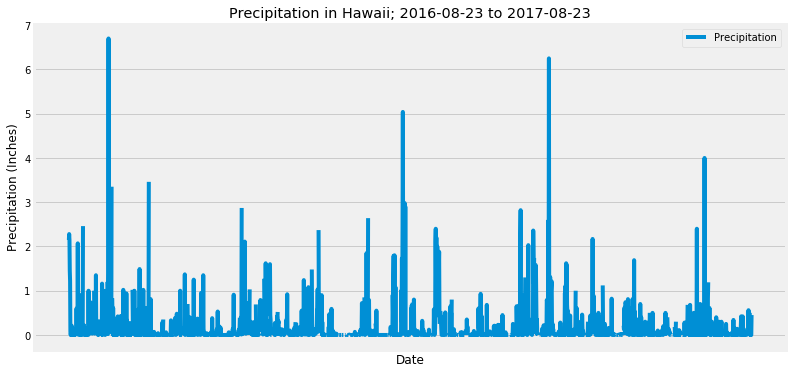

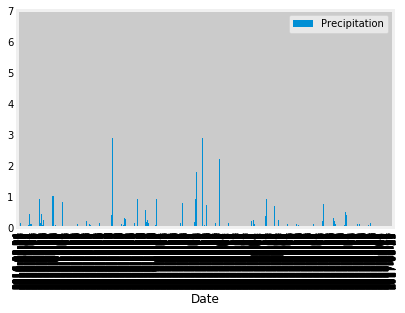

In [8]:
#-- Plot Results

#- Set Chart Metadata
precipitation_df.plot(figsize=(12, 6))

plt.title(f"Precipitation in Hawaii; {startDate.strftime('%Y-%m-%d')} to {lastDate.strftime('%Y-%m-%d')}")
plt.ylabel('Precipitation (Inches)')
          
plt.xlabel("Date")
plt.xticks([])
  
#- Create Plot
precipitation_df.plot.bar()

#- Display
plt.show()

In [9]:
#-- Summary Statistics
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## 1.2 Station Analysis
* Design a query to calculate the total number of stations.
* Design a query to find the most active stations.
** List the stations and observation counts in descending order.
** Which station has the highest number of observations?
** Hint: You may need to use functions such as func.min, func.max, func.avg, and func.count in your queries.

* Design a query to retrieve the last 12 months of temperature observation data (tobs).
** Filter by the station with the highest number of observations.
** Plot the results as a histogram with bins=12.

In [10]:
#-- Stations within Dataset
numStations = session.query(Station).count()

print(f"Number of stations within dataset: {numStations}")

Number of stations within dataset: 9


In [11]:
#-- Most Active Stations
activeStations = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

activeStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [12]:
#-- Metadata from Active Station

#- Get Active Station
activeStationID = activeStations[0][0]

#- Query for Temperature Information
activeStationTemp = session.query(func.min(Measurement.tobs), \
                                  func.max(Measurement.tobs), \
                                  func.avg(Measurement.tobs))\
                                .filter(Measurement.station == activeStationID).all()

print(f"Lowest temperature recorded: {activeStationTemp[0][0]}")
print(f"Highest temperature recorded: {activeStationTemp[0][1]}")
print(f"Average temperature: {activeStationTemp[0][2]}")

Lowest temperature recorded: 54.0
Highest temperature recorded: 85.0
Average temperature: 71.66378066378067


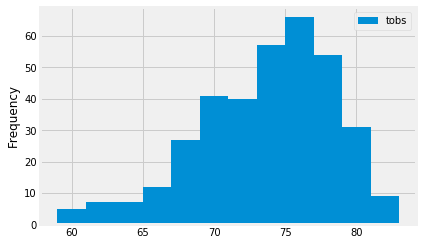

In [13]:
#-- Get Date Range
#- Get End Date
activeStationLastObservation = session.query(func.max(Measurement.date))\
    .filter(Measurement.station == activeStationID).scalar()

activeStationLastObservation

#- Convert to DateTime from String
activeStationLastDate = datetime.strptime(activeStationLastObservation, '%Y-%m-%d')


#- 12 Months from last date
activeStationStartDate = activeStationLastDate - relativedelta(years=1)


#-- Get Records
activeStationTemps = session.query(Measurement.tobs)\
                        .filter(Measurement.date.between(activeStationStartDate, activeStationLastDate))\
                        .filter(Measurement.station == activeStationID).all()


#-- Create Data Frame
activeStationTemps_df = pd.DataFrame(activeStationTemps, columns=['tobs'])


#-- Plot Histogram
activeStationTemps_df.plot.hist(bins = 12)


## 1.3 Temperature Analysis
* The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
* Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").
* Plot the min, avg, and max temperature from your previous query as a bar chart.
** Use the average temperature as the bar height.
** Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [14]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [15]:
#-- Determine Temperature Metadata

#- Vacation Dates
startVacation = "2016-09-13"
endVacation = "2016-09-27"


#- Calculate Metadata
vacationStats = calc_temps(startVacation, endVacation)

vacationMinTemp = vacationStats[0][0]

vacationAveTemp = vacationStats[0][1]

vacationMaxTemp = vacationStats[0][2]


#- Calculate Peak Range
vacationRangeTemp = vacationMaxTemp - vacationMinTemp


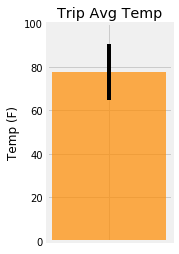

In [32]:
#-- Plot Trip Avg Temp

#- Set size
plt.figure(figsize=(2,4))

#- Create Bar Chart
plt.bar('', vacationAveTemp, alpha=0.7, yerr=vacationRangeTemp, color='darkorange')

#- Set Labels
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.xlabel('')

#- Y Axis Limits
plt.ylim(0, 100)

#- Display Chart
plt.show()


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
